Here we apply a simple method to extract cell-cell interactions from cell type specific AOIs in Nanostring data, based on correlations between spatially varying genes in the EOMESplus population and HOPXplus population.

In [1]:
## Goal is to find spatially varying ligand receptor pairs that correlate with EOMES+ spatially varying genes:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'floatX=' + data_type #+ ',force_device=True'
%matplotlib inline
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
#gfd
import theano
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

os.chdir('/nfs/team283/aa16/KR_NAS/')
rSlides = ('00MU', '00MV', '00MV-2')
AOI_type = 'Geometric'
Radial_position = 2

# Let's load the data and metadata from our Nanostring experiment:
counts = pd.read_table('Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
counts = counts[np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288]
metadata = pd.read_csv('/nfs/team283/aa16/KR_NAS/NanoString sequencing all annotations 2020.02.10_original.csv')
metadata = metadata.iloc[0:289,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table('Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))] 

# Let's load the Polioudakis 2019 data as a reference, as well as the cell type specific marker genes:

subset_rois = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == Radial_position and metadata['AOI_type'][i] == AOI_type for i in range(len(metadata['slide']))]
relevantIDs = metadata['Sample_ID'][subset_rois]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_rois]
counts_subset = counts.loc[:,relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

# Spatially varying genes in EOMES+ population:

eomesVariableGenes = pickle.load(open('resultLists/eomesSpatialGenes.pickle', 'rb'))
eomesVariableGenes = eomesVariableGenes[1:32]

# Load all the receptor-ligand pairs from CellPhoneDB:

cellPhoneDB_geneInput = pd.read_csv('../data/CellPhoneDB/gene_input.csv')
cellPhoneDB_geneInput = cellPhoneDB_geneInput.drop_duplicates(subset = 'uniprot')
cellPhoneDB_geneInput.index = cellPhoneDB_geneInput['uniprot']
cellPhoneDB_proteinInput = pd.read_csv('../data/CellPhoneDB/protein_input.csv')
cellPhoneDB_proteinInput = cellPhoneDB_proteinInput.drop_duplicates(subset = 'uniprot')
cellPhoneDB_geneInput = cellPhoneDB_geneInput.reindex(np.array(cellPhoneDB_proteinInput['uniprot']))

cellPhoneDB_genes_ligand = cellPhoneDB_geneInput['gene_name'].iloc[np.array(~cellPhoneDB_proteinInput['receptor'])]
cellPhoneDB_genes_receptor = cellPhoneDB_geneInput['gene_name'].iloc[np.array(cellPhoneDB_proteinInput['receptor'])]
receptors = cellPhoneDB_genes_receptor[[cellPhoneDB_genes_receptor[i] in np.array(counts.index) for i in range(len(cellPhoneDB_genes_receptor))]]

# Find all receptors expressed in EOMESplus population and check if their ligands' expression varies with cortical depth:

subset_eomes = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3) and metadata['AOI_type'][i] == 'EOMESpos' for i in range(len(metadata['slide']))]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_eomes]
relevantIDs = metadata['Sample_ID'][subset_eomes]
counts_subset = counts.loc[np.array(receptors),relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

binary = [sum([counts_subset.loc[receptors[i]].iloc[j] > newLOD_2_subset.iloc[j] for j in range(len(newLOD_2_subset))]) > 10 for i in range(len(receptors))]
receptors = receptors[binary]

# receptors_proteins[0] in np.array(cellPhoneDB_interactions['partner_a'])

# Find ligands for these receptors:

cellPhoneDB_interactions = pd.read_csv('../data/CellPhoneDB/interaction_input.csv')
receptors_proteins = [cellPhoneDB_geneInput.index[np.where(cellPhoneDB_geneInput['gene_name'] == receptors[i])][0] for i in range(len(receptors))]

ligand_proteins = np.repeat('EmptyEmptyEmpty', len(receptors_proteins))
for i in range(len(ligand_proteins)):
    if sum(cellPhoneDB_interactions['partner_a'] == receptors_proteins[i]) > 0:
        ligand_proteins[i] = cellPhoneDB_interactions['partner_b'].loc[cellPhoneDB_interactions['partner_a'] == receptors_proteins[i]].iloc[0]
    if sum(cellPhoneDB_interactions['partner_b'] == receptors_proteins[i]) > 0:
        ligand_proteins[i] = cellPhoneDB_interactions['partner_a'].loc[cellPhoneDB_interactions['partner_b'] == receptors_proteins[i]].iloc[0]

receptors_proteins = np.array(receptors_proteins)    
sub = [ligand_proteins[i] != 'EmptyEmptyEmpty' and ligand_proteins[i] != 'BMPR1B_BMPR2' for i in range(len(ligand_proteins))]
receptors_proteins = receptors_proteins[sub]
ligand_proteins = ligand_proteins[sub]

eomes_ligand_genes = [np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == ligand_proteins[i])][0] for i in range(len(ligand_proteins))]

eomes_receptor_genes = [np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == receptors_proteins[i])][0] for i in range(len(ligand_proteins))]

print(eomes_receptor_genes[eomes_ligand_genes == 'CRH'])
print(eomes_receptor_genes[eomes_ligand_genes == 'ERBB4'])

eomes_ligand_genes = np.unique(eomes_ligand_genes)

norm_expr = NaiveDE.stabilize(counts.T).T

resid_expr = NaiveDE.regress_out(sample_info, norm_expr, 'np.log(Q3_counts)').T
subset_eomesLigands = [resid_expr.keys()[i] in eomes_ligand_genes for i in range(len(resid_expr.keys()))]
resid_expr_subset = resid_expr.loc[subset_rois, subset_eomesLigands]

X = sample_info[['x', 'y']][subset_rois]
results = SpatialDE.run(X, resid_expr_subset)

results = results.sort_values('qval')
genes_ranked = np.array(results['g'])
genes_significant = sum(multi.multipletests(results['pval'], method = 'fdr_bh')[1] < 0.05)

results['FDR'] = multi.multipletests(results['pval'], method = 'fdr_bh')[1]

variableLigands = np.array(results['g'][results['FDR'] < 0.05])

Populating the interactive namespace from numpy and matplotlib


/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


FileNotFoundError: [Errno 2] File Sanger_288ROIs_TargetCountMatrix.txt does not exist: 'Sanger_288ROIs_TargetCountMatrix.txt'

Rank ligands by correlation with EOMES spatially varying genes:

In [92]:


subsetEOMES = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'EOMESpos' for i in range(len(metadata['slide']))]
subsetHOPX = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'HOPXpos' for i in range(len(metadata['slide']))]
subsetResidual = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'Residual' for i in range(len(metadata['slide']))]
subsetRings = [metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'Rings' for i in range(len(metadata['slide']))]

# expressionData2 = np.array(resid_expr.loc[subsetEOMES, eomesVariableGenes])
# expressionData2 = expressionData2[np.argsort(metadata['VCDepth'][subsetEOMES]),:]

# expressionData = np.concatenate((expressionData1, expressionData2), axis = 1)

# expressionDataDF = pd.DataFrame(expressionData, columns = np.concatenate((variableLigands, eomesVariableGenes)))

# correlationMatrix = np.corrcoef(expressionDataDF.T)

# #sns.clustermap(expressionDataDF.T)

# fig, ax = plt.subplots(1,1, figsize=(15,15))

# img = ax.imshow(correlationMatrix)

# x_label_list = np.concatenate((variableLigands, eomesVariableGenes))

# ax.set_xticks(np.arange(len(x_label_list)))
# ax.set_yticks(np.arange(len(x_label_list)))

# ax.set_xticklabels(x_label_list)
# ax.set_yticklabels(x_label_list)

# plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#          rotation_mode="anchor")

# fig.colorbar(img)

Now try to use geometic mean expression of normalized raw counts of receptor ligand pairs instead and also use residuals instead of adjacent ROIs.

In [93]:
orderEOMES = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'EOMESpos' for i in range(len(metadata['slide']))])[0]
orderEOMES = orderEOMES[np.argsort(metadata['VCDepth'][subsetEOMES] + metadata['Radial_position'][subsetEOMES]*10**(-6))]
orderEOMES = numpy.delete(orderEOMES, 3) # Bad AOI

In [94]:
orderHOPX = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'HOPXpos' for i in range(len(metadata['slide']))])[0]
orderHOPX = orderHOPX[np.argsort(metadata['VCDepth'][subsetHOPX] + metadata['Radial_position'][subsetHOPX]*10**(-6))]
orderHOPX = numpy.delete(orderHOPX, 3) # Bad AOI

In [95]:
orderResidual = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'Residual' for i in range(len(metadata['slide']))])[0]
orderResidual = orderResidual[np.argsort(metadata['VCDepth'][subsetResidual] + metadata['Radial_position'][subsetResidual]*10**(-6))]
#orderResidual = numpy.delete(orderResidual, 3) # Bad AOI

In [96]:
orderRings = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in np.array((1,2,3)) and metadata['AOI_type'][i] in 'Ring' for i in range(len(metadata['slide']))])[0]
orderRings = orderRings[np.argsort(metadata['VCDepth'][subsetRings] + metadata['Radial_position'][subsetRings]*10**(-6))]
#orderRings = numpy.delete(orderRings, 3) # Bad AOI

In [97]:
normCounts_EOMES = np.array([counts.iloc[:,orderEOMES[i]]/sum(counts.iloc[:,orderEOMES[i]]) for i in range(len(orderResidual))])*10**6

In [215]:
normCounts_Background = np.array([(counts.iloc[:,orderResidual[i]] + counts.iloc[:,orderHOPX[i]])/sum(counts.iloc[:,orderResidual[i]] + counts.iloc[:,orderHOPX[i]]) for i in range(len(orderResidual))])*10**6

In [176]:
Counts_Background = np.array([(counts.iloc[:,orderResidual[i]] + counts.iloc[:,orderHOPX[i]]) for i in range(len(orderResidual))])

In [100]:
metadata['Radial_position'][orderHOPX]

HCA_F_BRA8739104    3.0
HCA_F_BRA8739197    1.0
HCA_F_BRA8739259    3.0
HCA_F_BRA8739350    1.0
HCA_F_BRA8739229    1.0
HCA_F_BRA8739196    3.0
HCA_F_BRA8739166    1.0
HCA_F_BRA8739167    3.0
HCA_F_BRA8739261    1.0
HCA_F_BRA8739228    3.0
HCA_F_BRA8739360    1.0
HCA_F_BRA8739136    3.0
HCA_F_BRA8739198    1.0
HCA_F_BRA8739260    3.0
HCA_F_BRA8739103    1.0
HCA_F_BRA8739168    3.0
HCA_F_BRA8739230    1.0
HCA_F_BRA8739262    3.0
HCA_F_BRA8739135    1.0
HCA_F_BRA8739295    3.0
Name: Radial_position, dtype: float64

In [109]:
counts_new = counts
sample_info_new = sample_info
counts_new.iloc[:,orderResidual] = np.array(counts_new.iloc[:,orderResidual]) + np.array(counts_new.iloc[:,orderHOPX])
sample_info_new.iloc[orderResidual, 2] = np.array(sample_info_new.iloc[orderResidual, 2]) + np.array(sample_info_new.iloc[orderHOPX, 2])
sample_info_new.iloc[orderResidual, 3] = np.array(sample_info_new.iloc[orderResidual, 3]) + np.array(sample_info_new.iloc[orderHOPX, 3])

In [113]:
norm_expr = NaiveDE.stabilize(counts_new.T).T

resid_expr = NaiveDE.regress_out(sample_info_new, norm_expr, 'np.log(Q3_counts)').T

subset_eomesLigands = [resid_expr.keys()[i] in eomes_ligand_genes for i in range(len(resid_expr.keys()))]
resid_expr_subset = resid_expr.iloc[orderResidual, subset_eomesLigands]

X = sample_info_new[['x', 'y']].iloc[orderResidual]
results = SpatialDE.run(X, resid_expr_subset)

results = results.sort_values('qval')
genes_ranked = np.array(results['g'])
genes_significant = sum(multi.multipletests(results['pval'], method = 'fdr_bh')[1] < 0.05)

results['FDR'] = multi.multipletests(results['pval'], method = 'fdr_bh')[1]

variableLigands = np.array(results['g'][results['pval'] < 0.25])

In [114]:
variableLigands

array(['SEMA4D', 'ERBB4', 'CRH', 'PTN', 'EGF', 'CSF1', 'SPP1', 'FGF7',
       'FGF6', 'FGFR1', 'TNF', 'MDK', 'WNT3', 'CD72', 'CD70', 'FGFR2',
       'EPO', 'EFNA4', 'CKLF', 'CORT', 'GAL', 'WNT5A', 'EFNB2'],
      dtype=object)

In [147]:
eomes_ligand_genes = np.array([np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == ligand_proteins[i])][0] for i in range(len(ligand_proteins))])
eomes_receptor_genes = np.array([np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == receptors_proteins[i])][0] for i in range(len(ligand_proteins))])
variableReceptors = eomes_receptor_genes[[np.where(eomes_ligand_genes == variableLigands[i])[0][0] for i in range(len(variableLigands))]]
variableReceptorsIndex = [np.where(counts.index == variableReceptors[i])[0][0] for i in range(len(variableReceptors))]
variableLigandsIndex = [np.where(counts.index == variableLigands[i])[0][0] for i in range(len(variableLigands))]
eomesVariableGenesIndex = [np.where(counts.index == eomesVariableGenes[i])[0][0] for i in range(len(eomesVariableGenes))]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [116]:
EOMESreceptors = normCounts[orderEOMES,:][:,variableReceptorsIndex]
ResidualLigands = normCounts[orderResidual,:][:,variableLigandsIndex]
GeometricMean = [np.sqrt(EOMESreceptors[:,i]*ResidualLigands[:,i]) for i in range(np.shape(EOMESreceptors)[1])] # Probably won't use it

Cluster variable EOMES variable genes into two groups:

In [118]:
from sklearn.cluster import AgglomerativeClustering

expressionData2 = np.array(resid_expr.loc[subsetEOMES, eomesVariableGenes])

correlationMatrix = np.corrcoef(expressionData2.T)

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
groups = cluster.fit_predict(correlationMatrix)

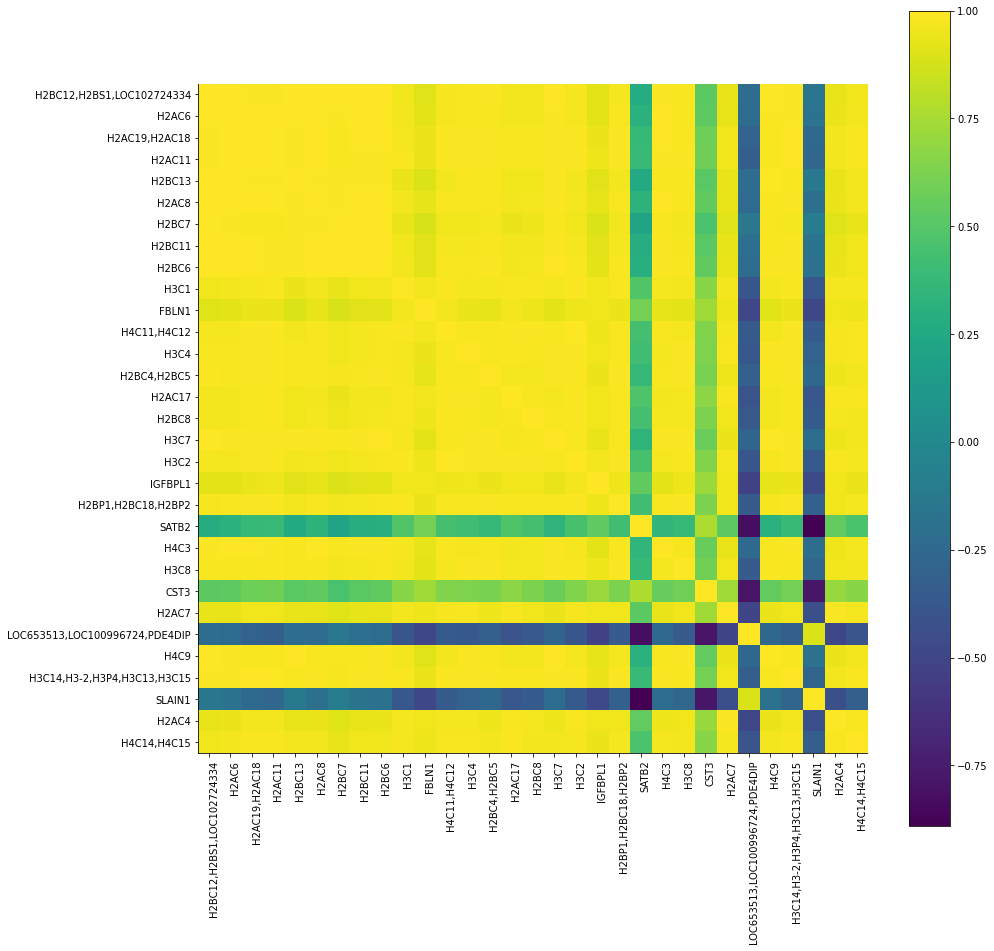

In [119]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

img = ax.imshow(correlationMatrix) 

x_label_list =  eomesVariableGenes

ax.set_xticks(np.arange(len(x_label_list)))
ax.set_yticks(np.arange(len(x_label_list)))

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(x_label_list)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

fig.colorbar(img)

Now calculate average correlation with both groups:

In [120]:
group0 = eomesVariableGenes[groups == 0]
group1 = eomesVariableGenes[groups == 1]

In [127]:
expressionData1 = normCounts_Background[:,variableLigandsIndex]

expressionData2 = normCounts_EOMES[:,eomesVariableGenesIndex]

expressionData = np.concatenate((expressionData1, expressionData2), axis = 1)

expressionDataDF = pd.DataFrame(expressionData, columns = np.concatenate((variableLigands, eomesVariableGenes)))
correlationMatrix = np.corrcoef(expressionDataDF.T)
correlationMatrixDF = pd.DataFrame(correlationMatrix, columns = np.concatenate((variableLigands, eomesVariableGenes)),
                                  index = np.concatenate((variableLigands, eomesVariableGenes)))

topGenes_Group0 = variableLigands[np.argsort(-abs(np.mean(correlationMatrixDF.loc[variableLigands, group0], axis = 1)))]

print(np.mean(correlationMatrixDF.loc[variableLigands, group0], axis = 1)[np.argsort(-abs(np.mean(correlationMatrixDF.loc[variableLigands, group0], axis = 1)))])

topGenes_Group1 = variableLigands[np.argsort(-abs(np.mean(correlationMatrixDF.loc[variableLigands, group1], axis = 1)))]

print(np.mean(correlationMatrixDF.loc[variableLigands, group1], axis = 1)[np.argsort(-abs(np.mean(correlationMatrixDF.loc[variableLigands, group1], axis = 1)))])


CRH       0.777109
ERBB4    -0.656916
SEMA4D    0.568362
PTN       0.566258
SPP1     -0.445990
EPO      -0.359423
FGFR1     0.305075
MDK       0.279753
TNF      -0.257242
GAL      -0.221255
EFNA4    -0.214706
CSF1     -0.189166
FGFR2     0.147754
EGF      -0.133220
FGF7     -0.123259
FGF6      0.093286
WNT5A    -0.085441
CD70      0.080894
CKLF      0.078190
CD72     -0.075098
CORT     -0.052831
EFNB2    -0.036045
WNT3     -0.002377
dtype: float64
ERBB4     0.955875
SEMA4D   -0.848542
CRH      -0.654301
SPP1      0.650716
PTN      -0.620690
EPO       0.363254
CSF1      0.261220
EFNA4     0.247956
FGFR1    -0.239286
WNT5A     0.217486
MDK      -0.208690
WNT3     -0.207706
TNF       0.206409
FGFR2    -0.198497
EGF       0.178792
CD72      0.157166
FGF7      0.152293
GAL       0.103483
EFNB2    -0.078685
CD70      0.048321
CKLF      0.048164
CORT      0.036086
FGF6     -0.001966
dtype: float64


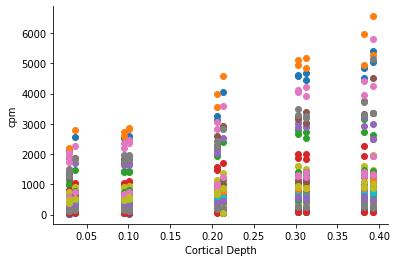

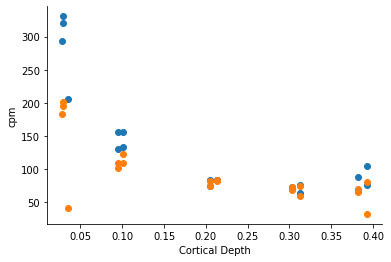

In [125]:
for i in range(sum(groups == 0)):
    plt.scatter(metadata['VCDepth'][orderEOMES], normCounts[orderEOMES,:][:,np.array(eomesVariableGenesIndex)[groups == 0][i]])
    plt.ylabel('cpm')
    plt.xlabel('Cortical Depth')
plt.show()

for i in range(sum(groups == 1)):
    plt.scatter(metadata['VCDepth'][orderResidual], normCounts[orderEOMES,:][:,np.array(eomesVariableGenesIndex)[groups == 1][i]])
    plt.ylabel('cpm')
    plt.xlabel('Cortical Depth')
plt.show()

Now make a plot of top correlated genes with each group, including ligand and receptor expression in residual and eomesPos population respectively. Also include reference ring in slightly transparent colour.

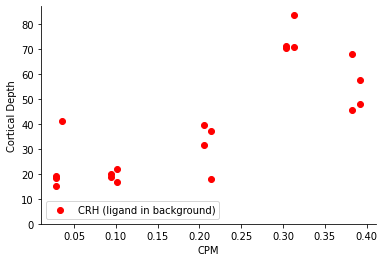

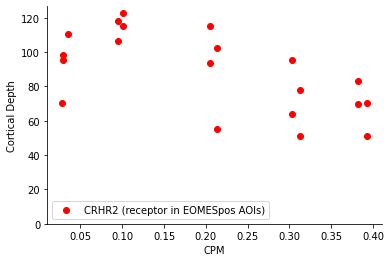

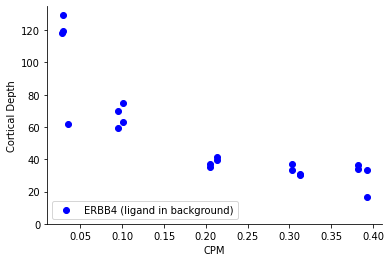

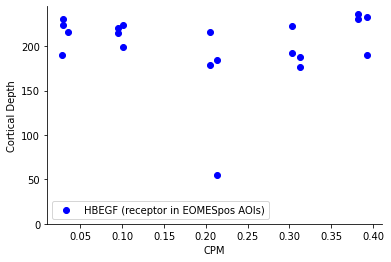

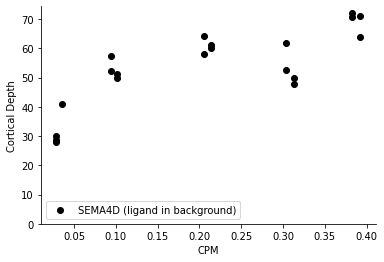

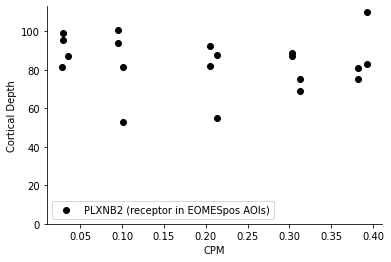

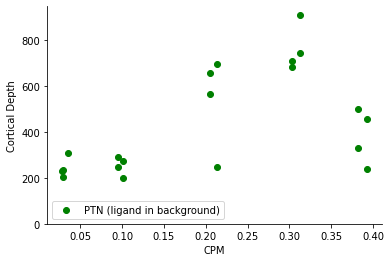

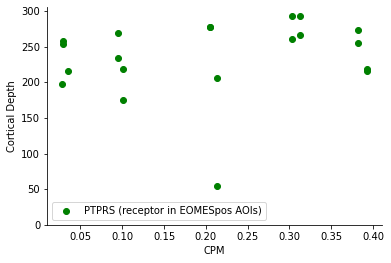

In [132]:
colours = np.array(('red', 'blue', 'black', 'green', 'purple'))

for i in range(4):

    plt.scatter(metadata['VCDepth'][orderEOMES], normCounts_Background[:,counts.index == topGenes_Group0[i]], label = topGenes_Group0[i]  + ' (ligand in background)', c = colours[i])
    plt.legend(loc = 'lower left')
    plt.ylim(ymin=0)
    plt.xlabel('CPM')
    plt.ylabel('Cortical Depth')
    plt.show()

    receptor = eomes_receptor_genes[np.where(eomes_ligand_genes == topGenes_Group0[i])[0][0]]

    plt.scatter(metadata['VCDepth'][orderEOMES], normCounts_EOMES[:,counts.index == receptor], label = receptor  + ' (receptor in EOMESpos AOIs)', c = colours[i])
    plt.legend(loc = 'lower left')
    plt.ylim(ymin=0)
    plt.xlabel('CPM')
    plt.ylabel('Cortical Depth')
    plt.show()

In [324]:
eomes_receptor_genes[np.where(eomes_ligand_genes == topGenes_Group0[i])[0][0]]

'HBEGF'

Now make an overview of ligand-receptor interactions as function of cortical depth:

In [137]:
eomes_ligand_genes

array(['KIR3DL2', 'FAM3C', 'VEGFB', 'SEMA4D', 'CCL4L2', 'EFNB3', 'SEMA4D',
       'SEMA7A', 'GAL', 'WNT3', 'FAM3B', 'CKLF', 'NRG1', 'INS', 'IGF2',
       'FAM3C', 'FGF6', 'IGF2', 'FGFR1', 'JAG1', 'SPP1', 'LILRB1', 'FGF5',
       'FGF7', 'CD70', 'INHBE', 'EFNA1', 'VEGFA', 'GRP', 'CORT', 'CCL21',
       'WNT1', 'TNF', 'CCL3', 'EPO', 'EFNA4', 'EFNB2', 'EFNA3', 'EGF',
       'BMP8B', 'DLL1', 'MDK', 'TTR', 'LGALS9', 'IL16', 'VEGFA', 'CRH',
       'PTN', 'INHBC', 'LGALS9', 'TTR', 'BMP7', 'IL13', 'NRG1', 'IFNA8',
       'XCL1', 'MDK', 'CD72', 'TNFSF12', 'ERBB4', 'COPA', 'PLXNB2',
       'WNT1', 'GDF11', 'TNF', 'WNT5A', 'CSF1', 'PDCD1', 'FGFR2', 'MIF',
       'DLK1', 'EDA'], dtype='<U7')

In [139]:
newLOD_2 = properties['NegGeoMean_01']*(properties['NegGeoSD_01']**2) 

In [161]:
eomes_ligand_genesExists = np.array([eomes_ligand_genes[i] in counts.index for i in range(len(eomes_ligand_genes))])

In [162]:
eomes_ligand_genesIndex = [np.where(counts.index == eomes_ligand_genes[i])[0][0] for i in np.array(range(len(eomes_ligand_genes)))[eomes_ligand_genesExists]]

In [178]:
ligands_detected = [sum(Counts_Background[i,eomes_ligand_genesIndex] > newLOD_2[orderResidual][i]) for i in range(len(orderResidual))]

In [217]:
import scipy as sc
normCounts_Background = numpy.delete(normCounts_Background, 3, axis = 0) # Bad AOI
ligands_zscore = sc.stats.zscore(np.log2(normCounts_Background[:,eomes_ligand_genesIndex]), axis = 0)

Text(0.5, 0, 'Cortical Depth')

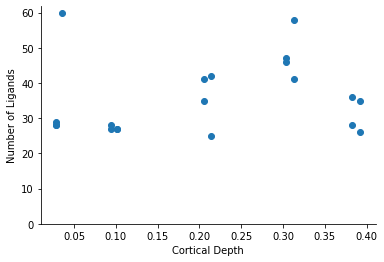

In [186]:
plt.scatter(metadata['VCDepth'][orderResidual], ligands_detected)
plt.ylim(ymin = 0)
plt.ylabel('Number of Ligands')
plt.xlabel('Cortical Depth')

Text(0.5, 0, 'Cortical Depth')

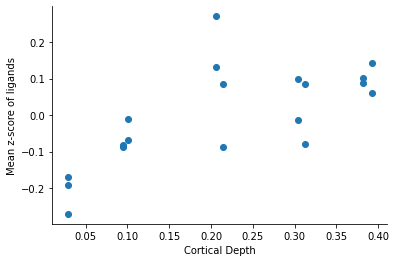

In [220]:
#orderResidual = np.delete(orderResidual,3)
plt.scatter(metadata['VCDepth'][orderResidual], mean(ligands_zscore, axis = 1))
plt.ylabel('Mean z-score of ligands')
plt.xlabel('Cortical Depth')

In [192]:
np.shape(ligands_zscore)

(20, 60)

In [193]:
len(orderResidual)

20

In [199]:
mean(ligands_zscore, axis = 1)

array([-8.78001375e-16, -6.45779726e-16,  4.92198874e-16,  4.71104637e-15,
       -1.60982339e-16, -2.57201667e-16,  7.26270895e-16,  1.67551158e-15,
       -3.41393580e-16, -3.35842465e-16, -1.37482618e-15, -1.31607688e-15,
       -6.18024150e-16,  2.37772764e-16, -2.72929827e-16, -9.91799235e-16,
        9.28886597e-16,  3.33066907e-16, -7.37373126e-16, -2.20194233e-16])

In [201]:
ligands_zscore

array([[ 1.87025822,  0.51931678, -0.14399625, ...,  0.6615536 ,
        -0.55082209, -0.32015689],
       [ 2.0192762 ,  0.38953167, -0.1005184 , ...,  0.26443524,
        -0.71158598, -0.44700025],
       [ 2.00767734,  0.42811276, -0.12107232, ...,  0.53398108,
        -0.58408212, -0.66626325],
       ...,
       [ 2.09868674,  0.04228358,  0.94489518, ...,  0.17930865,
        -0.76238602, -0.59078305],
       [ 1.91899089,  0.21166019,  0.77856724, ...,  0.38114192,
        -0.648905  , -0.29985659],
       [ 2.1085923 ,  0.45034501,  0.92970287, ...,  0.09637102,
        -0.08766287, -0.61943661]])

In [211]:
orderResidual[-3]

102

In [216]:
np.shape(normCounts_Background)

(20, 18119)